<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_for_odd_sized_images_ver16%20int10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is ensemble of 2 identical G

this step is to train each G seperately 

once each G generates meaniful results, then ensemble them

the way to train seperate is 
1) seperate train and load weights 
2) train with Avg (same G)


In [0]:
from IPython.display import Image
from keras.utils import plot_model
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

In [0]:
from IPython.display import Image
from keras.utils import plot_model

In [0]:
# Restart runtime to allow Jupyter to know the changes above
import os
#os._exit(0)

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average, merge
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

In [0]:
def load_dataold():
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([100000,28,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 1000):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([28,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage1
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*1000 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 600])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
def load_large_data5656():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:28, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
X_trainlarge = load_large_data()

In [0]:
X_trainlarge5656 = load_large_data5656()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  if (datasetname == 3):   
     X_train = X_trainlarge
  if (datasetname == 4):   
     X_train = X_trainlarge5656

  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
  #  print("-- Discriminator -- ")
   # model.summary()
    return model

In [0]:
def build_discriminator2856(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:


def plotamodel(amodel, showdetails=True):
  # Model summary
  print(amodel.summary())

  if (showdetails==True):
    # Plot model graph
    plot_model(amodel, show_shapes=True, show_layer_names=True, to_file='model.png')
    #Image(retina=True, filename='model.png')
  if (showdetails==False):
    # Plot model graph
    plot_model(amodel, show_shapes=False, show_layer_names=False, to_file='modelsmall.png')
   # Image(retina=True, filename='modelsmall.png')

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(2)
    X_train5656 = None
    
    if modeltotrain == 3:
          X_train5656 = load_databydatasetname(3)

    num_examples = X_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
        
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            if modeltotrain == 2:
              fake_images = fake_images2
              fake_labels = fake_labels2
            if modeltotrain == 3:
              noise2 = copy.deepcopy(noise1)
              fake_images3 = mergedmodel.predict(noise2)
              fake_labels3 = np.zeros((half_batch, 1))    
              fake_images = fake_images3
              fake_labels = fake_labels3              
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            X_train = X_trainlarge
            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)            
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs(generator1, epoch, batch)
            if batch % 101 == 0:
                 save_imgs(generator2, epoch, batch)
            if batch % 102 == 0:
                 save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNandriNEW(averagemode = 1, loadpretrainedweights=False):
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 56, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    if(averagemode == 1):
          models = [generator1, generator1]
    if(averagemode == 2):
          models = [generator2, generator2]
    if(averagemode == 3):
          models = [generator1, generator2]


  ##  models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    for obj1 in outputs:
      print(type(obj1))
      print(obj1.shape)
        
    mergedlayer = Concatenate(axis=2)(outputs)
    ##x = merge([lstm_out, auxiliary_input], mode='concat')
   ## output = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)
  #  mergedlayer = merge([generator1, generator2], mode='concat', concat_axis=1)
  
   #mergedlayer = merge([out1, out], mode='concat', concat_axis=1)
#contact axis can be -1 to 0 , 1 for inception , 2 , 3 or remove it
  #  mergedlayer = merge([generator1, generator1])

    print('merge layers')
    print(out1.shape)
    print(out.shape)
    print(mergedlayer.shape)

  

    
    
    mergedmodel = Model(z, mergedlayer)
    
    discriminator.trainable = False
    real = discriminator(mergedlayer)
    combined = Model(z, real)
        

    
    if(loadpretrainedweights==True):
      generator1.load_weights('my_model_weights_mnist.h5')
      #generator2.load_weights('my_model_weights_mnist.h5')
      #generator1 = load_model('generator2fmnist.h5')
      #generator2 = load_model('generator2fmnist.h5')
      

    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer) 
  
    plotamodel(mergedmodel)
   # plotamodel(combined)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [0]:

generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 3 ,  loadpretrainedweights=True)




    
    

    


In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/my_model_weights_mnist.h5

In [48]:
plotamodel(combined)
files.download('model.png')




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 6272)         633472      input_7[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 6272)         633472      input_7[0][0]                    
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 7, 7, 128)    0           dense_10[0][0]                   
__________________________________________________________________________________________________
reshape_8 

In [0]:
plotamodel(discriminator)
files.download('model.png')




In [0]:
#train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=10, modeltotrain=1)

Number of examples:  60000
Number of Batches:  1875
Number of epochs:  4
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 56, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/1875 [D loss: 0.963210, acc.: 34.38%] [G loss: 0.740825]


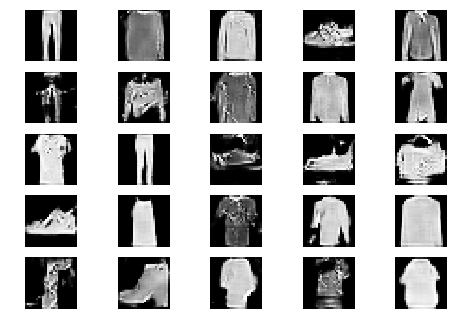

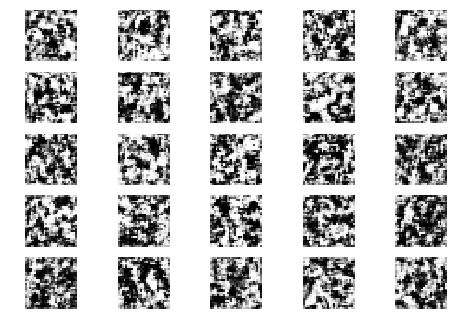

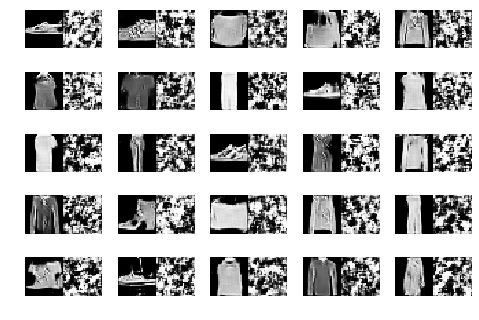

Epoch 0 Batch 1/1875 [D loss: 0.815938, acc.: 50.00%] [G loss: 0.711753]
Epoch 0 Batch 2/1875 [D loss: 0.638539, acc.: 62.50%] [G loss: 0.991228]
Epoch 0 Batch 3/1875 [D loss: 0.603484, acc.: 68.75%] [G loss: 1.461275]
Epoch 0 Batch 4/1875 [D loss: 0.526309, acc.: 71.88%] [G loss: 1.307152]
Epoch 0 Batch 5/1875 [D loss: 0.416862, acc.: 84.38%] [G loss: 1.557839]
Epoch 0 Batch 6/1875 [D loss: 0.398592, acc.: 87.50%] [G loss: 1.460239]
Epoch 0 Batch 7/1875 [D loss: 0.385137, acc.: 84.38%] [G loss: 1.757309]
Epoch 0 Batch 8/1875 [D loss: 0.552554, acc.: 81.25%] [G loss: 1.414485]
Epoch 0 Batch 9/1875 [D loss: 0.339133, acc.: 87.50%] [G loss: 1.963585]
Epoch 0 Batch 10/1875 [D loss: 0.380400, acc.: 81.25%] [G loss: 1.685203]
Epoch 0 Batch 11/1875 [D loss: 0.497260, acc.: 75.00%] [G loss: 1.498742]
Epoch 0 Batch 12/1875 [D loss: 0.516547, acc.: 78.12%] [G loss: 1.741993]
Epoch 0 Batch 13/1875 [D loss: 0.525323, acc.: 81.25%] [G loss: 1.398573]
Epoch 0 Batch 14/1875 [D loss: 0.501640, acc.: 

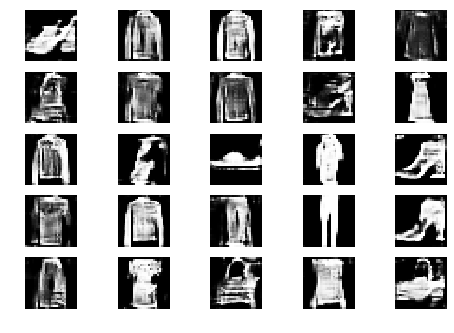

Epoch 0 Batch 101/1875 [D loss: 0.408379, acc.: 84.38%] [G loss: 1.882296]


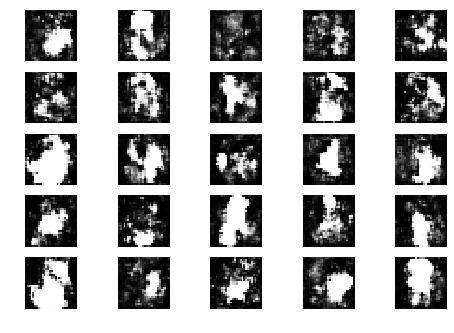

Epoch 0 Batch 102/1875 [D loss: 0.853570, acc.: 53.12%] [G loss: 1.640676]


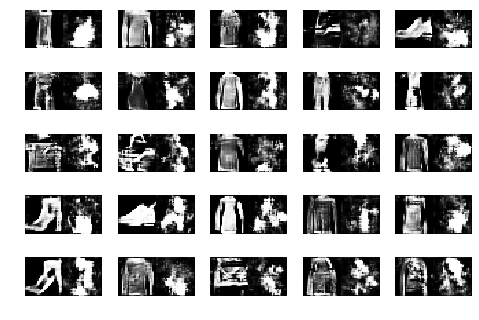

Epoch 0 Batch 103/1875 [D loss: 0.519733, acc.: 75.00%] [G loss: 2.180265]
Epoch 0 Batch 104/1875 [D loss: 0.599507, acc.: 62.50%] [G loss: 1.887266]
Epoch 0 Batch 105/1875 [D loss: 0.548455, acc.: 71.88%] [G loss: 2.402580]
Epoch 0 Batch 106/1875 [D loss: 0.358215, acc.: 81.25%] [G loss: 2.752275]
Epoch 0 Batch 107/1875 [D loss: 0.633678, acc.: 71.88%] [G loss: 1.989624]
Epoch 0 Batch 108/1875 [D loss: 0.450201, acc.: 71.88%] [G loss: 1.894221]
Epoch 0 Batch 109/1875 [D loss: 0.393302, acc.: 87.50%] [G loss: 3.207862]
Epoch 0 Batch 110/1875 [D loss: 0.431326, acc.: 71.88%] [G loss: 2.159750]
Epoch 0 Batch 111/1875 [D loss: 0.730119, acc.: 59.38%] [G loss: 1.829909]
Epoch 0 Batch 112/1875 [D loss: 0.580670, acc.: 68.75%] [G loss: 2.357694]
Epoch 0 Batch 113/1875 [D loss: 0.406126, acc.: 78.12%] [G loss: 2.668825]
Epoch 0 Batch 114/1875 [D loss: 0.271549, acc.: 90.62%] [G loss: 2.238888]
Epoch 0 Batch 115/1875 [D loss: 0.633567, acc.: 65.62%] [G loss: 2.031368]
Epoch 0 Batch 116/1875 [D

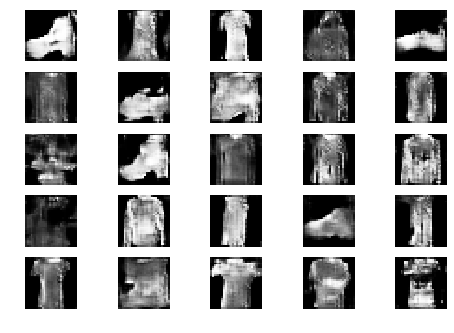

Epoch 0 Batch 201/1875 [D loss: 0.771927, acc.: 50.00%] [G loss: 1.874398]
Epoch 0 Batch 202/1875 [D loss: 0.644275, acc.: 65.62%] [G loss: 1.674576]


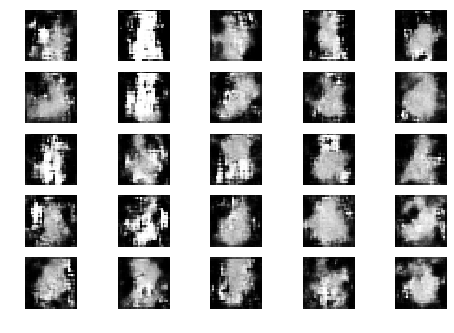

Epoch 0 Batch 203/1875 [D loss: 0.609645, acc.: 62.50%] [G loss: 1.480089]
Epoch 0 Batch 204/1875 [D loss: 0.526808, acc.: 75.00%] [G loss: 1.191380]


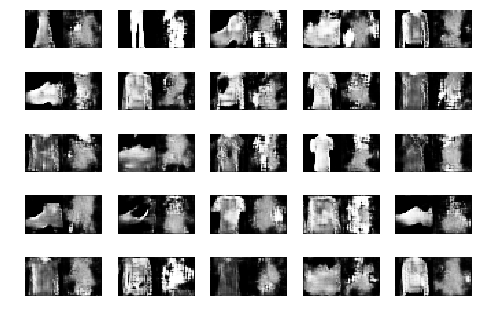

Epoch 0 Batch 205/1875 [D loss: 0.584069, acc.: 78.12%] [G loss: 1.265487]
Epoch 0 Batch 206/1875 [D loss: 0.604959, acc.: 75.00%] [G loss: 1.601007]
Epoch 0 Batch 207/1875 [D loss: 0.412161, acc.: 87.50%] [G loss: 1.515158]
Epoch 0 Batch 208/1875 [D loss: 0.686609, acc.: 65.62%] [G loss: 1.608872]
Epoch 0 Batch 209/1875 [D loss: 0.591560, acc.: 68.75%] [G loss: 1.839091]
Epoch 0 Batch 210/1875 [D loss: 0.538109, acc.: 68.75%] [G loss: 1.820567]
Epoch 0 Batch 211/1875 [D loss: 0.850667, acc.: 43.75%] [G loss: 1.396580]
Epoch 0 Batch 212/1875 [D loss: 0.524266, acc.: 78.12%] [G loss: 1.741548]
Epoch 0 Batch 213/1875 [D loss: 0.465156, acc.: 78.12%] [G loss: 1.864715]
Epoch 0 Batch 214/1875 [D loss: 0.604798, acc.: 75.00%] [G loss: 1.488088]
Epoch 0 Batch 215/1875 [D loss: 0.789448, acc.: 59.38%] [G loss: 2.012290]
Epoch 0 Batch 216/1875 [D loss: 0.381765, acc.: 81.25%] [G loss: 1.902418]
Epoch 0 Batch 217/1875 [D loss: 0.611865, acc.: 62.50%] [G loss: 1.428387]
Epoch 0 Batch 218/1875 [D

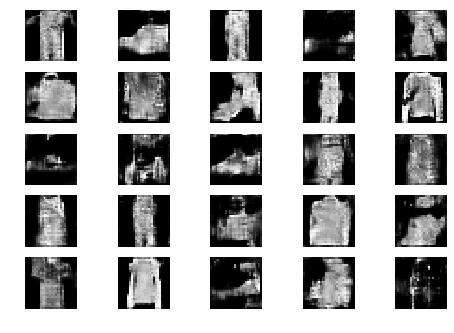

Epoch 0 Batch 301/1875 [D loss: 0.507429, acc.: 78.12%] [G loss: 2.430026]
Epoch 0 Batch 302/1875 [D loss: 0.574198, acc.: 75.00%] [G loss: 2.277790]
Epoch 0 Batch 303/1875 [D loss: 0.699422, acc.: 62.50%] [G loss: 1.603373]


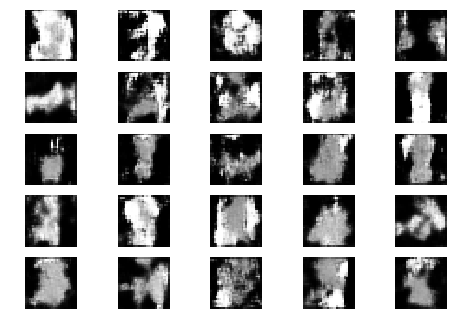

Epoch 0 Batch 304/1875 [D loss: 0.754658, acc.: 46.88%] [G loss: 1.438200]
Epoch 0 Batch 305/1875 [D loss: 0.440866, acc.: 78.12%] [G loss: 1.620283]
Epoch 0 Batch 306/1875 [D loss: 0.585770, acc.: 65.62%] [G loss: 1.503816]


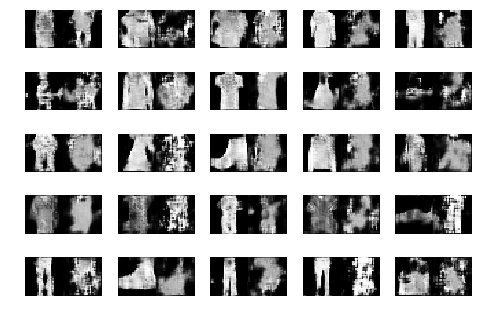

Epoch 0 Batch 307/1875 [D loss: 0.741441, acc.: 62.50%] [G loss: 1.412290]
Epoch 0 Batch 308/1875 [D loss: 0.643402, acc.: 71.88%] [G loss: 2.017135]
Epoch 0 Batch 309/1875 [D loss: 0.524260, acc.: 68.75%] [G loss: 1.461033]
Epoch 0 Batch 310/1875 [D loss: 0.636444, acc.: 68.75%] [G loss: 1.390235]
Epoch 0 Batch 311/1875 [D loss: 0.401609, acc.: 84.38%] [G loss: 1.392655]
Epoch 0 Batch 312/1875 [D loss: 0.615478, acc.: 71.88%] [G loss: 1.409365]
Epoch 0 Batch 313/1875 [D loss: 0.534687, acc.: 68.75%] [G loss: 1.578624]
Epoch 0 Batch 314/1875 [D loss: 0.586127, acc.: 71.88%] [G loss: 1.455029]
Epoch 0 Batch 315/1875 [D loss: 0.753502, acc.: 59.38%] [G loss: 1.415600]
Epoch 0 Batch 316/1875 [D loss: 0.707254, acc.: 59.38%] [G loss: 1.212876]
Epoch 0 Batch 317/1875 [D loss: 0.620299, acc.: 62.50%] [G loss: 1.693938]
Epoch 0 Batch 318/1875 [D loss: 0.642425, acc.: 75.00%] [G loss: 1.650457]
Epoch 0 Batch 319/1875 [D loss: 0.458886, acc.: 78.12%] [G loss: 1.705684]
Epoch 0 Batch 320/1875 [D

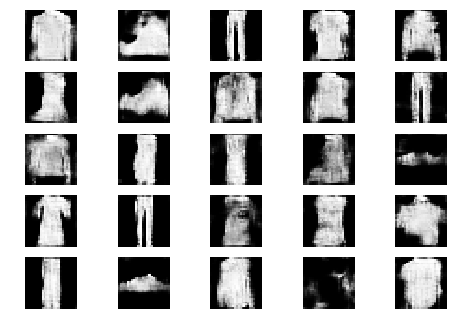

Epoch 0 Batch 401/1875 [D loss: 0.696034, acc.: 65.62%] [G loss: 1.665229]
Epoch 0 Batch 402/1875 [D loss: 0.631207, acc.: 59.38%] [G loss: 1.647126]
Epoch 0 Batch 403/1875 [D loss: 0.513773, acc.: 81.25%] [G loss: 1.803840]
Epoch 0 Batch 404/1875 [D loss: 0.455813, acc.: 81.25%] [G loss: 1.752367]


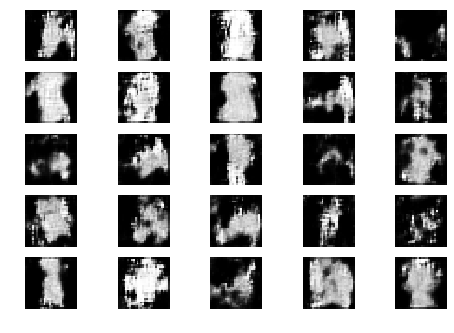

Epoch 0 Batch 405/1875 [D loss: 0.603261, acc.: 68.75%] [G loss: 1.812813]
Epoch 0 Batch 406/1875 [D loss: 0.262588, acc.: 87.50%] [G loss: 1.658982]
Epoch 0 Batch 407/1875 [D loss: 0.513789, acc.: 71.88%] [G loss: 1.347510]
Epoch 0 Batch 408/1875 [D loss: 0.341116, acc.: 90.62%] [G loss: 1.662769]


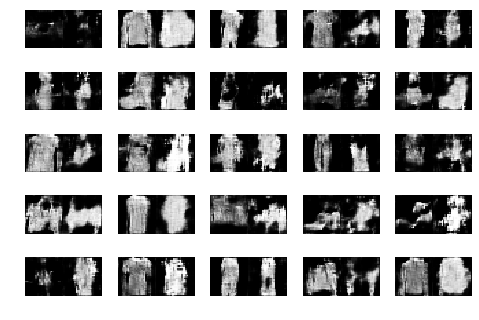

Epoch 0 Batch 409/1875 [D loss: 0.584237, acc.: 68.75%] [G loss: 1.784466]
Epoch 0 Batch 410/1875 [D loss: 0.598155, acc.: 68.75%] [G loss: 1.996223]
Epoch 0 Batch 411/1875 [D loss: 0.523028, acc.: 75.00%] [G loss: 1.722605]
Epoch 0 Batch 412/1875 [D loss: 0.718353, acc.: 56.25%] [G loss: 1.983684]
Epoch 0 Batch 413/1875 [D loss: 0.443598, acc.: 87.50%] [G loss: 1.647563]
Epoch 0 Batch 414/1875 [D loss: 0.637506, acc.: 65.62%] [G loss: 1.605718]
Epoch 0 Batch 415/1875 [D loss: 0.466080, acc.: 81.25%] [G loss: 1.294729]
Epoch 0 Batch 416/1875 [D loss: 0.688590, acc.: 62.50%] [G loss: 1.886068]
Epoch 0 Batch 417/1875 [D loss: 0.473250, acc.: 81.25%] [G loss: 1.653814]
Epoch 0 Batch 418/1875 [D loss: 0.486911, acc.: 75.00%] [G loss: 1.672298]
Epoch 0 Batch 419/1875 [D loss: 0.280662, acc.: 87.50%] [G loss: 1.442605]
Epoch 0 Batch 420/1875 [D loss: 0.470138, acc.: 75.00%] [G loss: 1.763976]
Epoch 0 Batch 421/1875 [D loss: 0.538419, acc.: 71.88%] [G loss: 1.335774]
Epoch 0 Batch 422/1875 [D

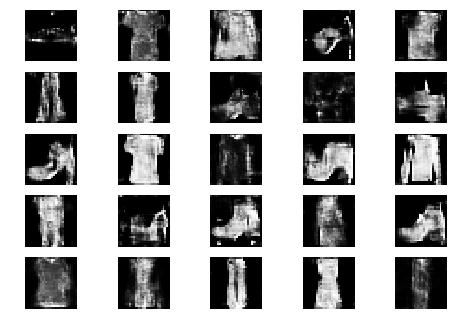

Epoch 0 Batch 501/1875 [D loss: 0.573746, acc.: 68.75%] [G loss: 1.182675]
Epoch 0 Batch 502/1875 [D loss: 0.345091, acc.: 90.62%] [G loss: 1.154514]
Epoch 0 Batch 503/1875 [D loss: 0.602791, acc.: 65.62%] [G loss: 1.962801]
Epoch 0 Batch 504/1875 [D loss: 0.479170, acc.: 78.12%] [G loss: 1.544901]
Epoch 0 Batch 505/1875 [D loss: 0.514679, acc.: 75.00%] [G loss: 2.060615]


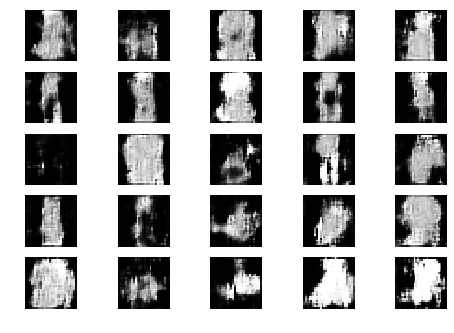

Epoch 0 Batch 506/1875 [D loss: 0.536208, acc.: 71.88%] [G loss: 1.754242]
Epoch 0 Batch 507/1875 [D loss: 0.626448, acc.: 75.00%] [G loss: 1.577705]
Epoch 0 Batch 508/1875 [D loss: 0.324474, acc.: 87.50%] [G loss: 1.829405]
Epoch 0 Batch 509/1875 [D loss: 0.713125, acc.: 53.12%] [G loss: 1.284737]
Epoch 0 Batch 510/1875 [D loss: 0.483445, acc.: 78.12%] [G loss: 1.602066]


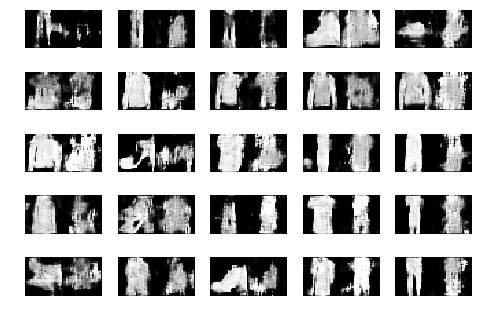

Epoch 0 Batch 511/1875 [D loss: 0.681051, acc.: 71.88%] [G loss: 1.825471]
Epoch 0 Batch 512/1875 [D loss: 0.586745, acc.: 65.62%] [G loss: 2.000894]
Epoch 0 Batch 513/1875 [D loss: 0.423797, acc.: 71.88%] [G loss: 1.411246]
Epoch 0 Batch 514/1875 [D loss: 0.488513, acc.: 75.00%] [G loss: 1.753773]
Epoch 0 Batch 515/1875 [D loss: 0.336105, acc.: 90.62%] [G loss: 1.879561]
Epoch 0 Batch 516/1875 [D loss: 0.673764, acc.: 62.50%] [G loss: 1.697753]
Epoch 0 Batch 517/1875 [D loss: 0.420471, acc.: 78.12%] [G loss: 2.039309]
Epoch 0 Batch 518/1875 [D loss: 0.347966, acc.: 81.25%] [G loss: 1.727418]
Epoch 0 Batch 519/1875 [D loss: 0.681485, acc.: 53.12%] [G loss: 1.327615]
Epoch 0 Batch 520/1875 [D loss: 0.508439, acc.: 71.88%] [G loss: 1.657771]
Epoch 0 Batch 521/1875 [D loss: 0.546795, acc.: 81.25%] [G loss: 1.676450]
Epoch 0 Batch 522/1875 [D loss: 0.500845, acc.: 78.12%] [G loss: 2.132118]
Epoch 0 Batch 523/1875 [D loss: 0.502241, acc.: 84.38%] [G loss: 1.906137]
Epoch 0 Batch 524/1875 [D

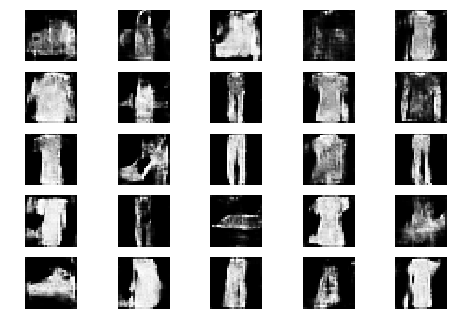

Epoch 0 Batch 601/1875 [D loss: 0.379651, acc.: 90.62%] [G loss: 2.107619]
Epoch 0 Batch 602/1875 [D loss: 0.421851, acc.: 78.12%] [G loss: 1.650368]
Epoch 0 Batch 603/1875 [D loss: 0.393417, acc.: 87.50%] [G loss: 2.025268]
Epoch 0 Batch 604/1875 [D loss: 0.859836, acc.: 56.25%] [G loss: 1.994387]
Epoch 0 Batch 605/1875 [D loss: 0.744207, acc.: 56.25%] [G loss: 1.554090]
Epoch 0 Batch 606/1875 [D loss: 0.554572, acc.: 78.12%] [G loss: 1.924404]


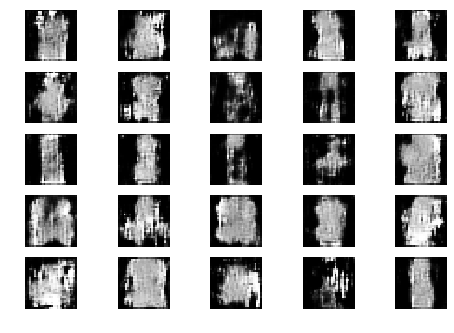

Epoch 0 Batch 607/1875 [D loss: 0.444351, acc.: 78.12%] [G loss: 1.940281]
Epoch 0 Batch 608/1875 [D loss: 0.441205, acc.: 78.12%] [G loss: 2.357909]
Epoch 0 Batch 609/1875 [D loss: 0.536380, acc.: 78.12%] [G loss: 1.747683]
Epoch 0 Batch 610/1875 [D loss: 0.617622, acc.: 71.88%] [G loss: 1.676412]
Epoch 0 Batch 611/1875 [D loss: 0.551289, acc.: 68.75%] [G loss: 1.729056]
Epoch 0 Batch 612/1875 [D loss: 0.661442, acc.: 81.25%] [G loss: 1.824254]


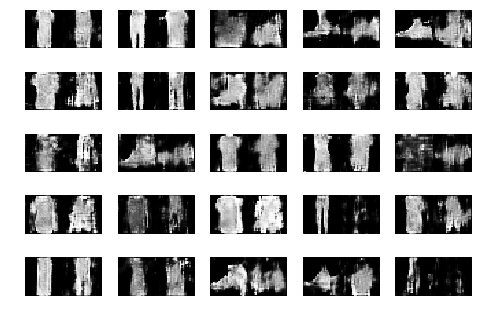

Epoch 0 Batch 613/1875 [D loss: 0.418836, acc.: 87.50%] [G loss: 1.810219]
Epoch 0 Batch 614/1875 [D loss: 0.581211, acc.: 71.88%] [G loss: 1.781293]
Epoch 0 Batch 615/1875 [D loss: 0.552916, acc.: 75.00%] [G loss: 1.471715]
Epoch 0 Batch 616/1875 [D loss: 0.542584, acc.: 71.88%] [G loss: 1.680929]
Epoch 0 Batch 617/1875 [D loss: 0.647372, acc.: 56.25%] [G loss: 1.999344]
Epoch 0 Batch 618/1875 [D loss: 0.555208, acc.: 59.38%] [G loss: 1.947181]
Epoch 0 Batch 619/1875 [D loss: 0.453815, acc.: 81.25%] [G loss: 1.845877]
Epoch 0 Batch 620/1875 [D loss: 0.388162, acc.: 81.25%] [G loss: 1.791757]
Epoch 0 Batch 621/1875 [D loss: 0.289379, acc.: 96.88%] [G loss: 2.153653]
Epoch 0 Batch 622/1875 [D loss: 0.536350, acc.: 81.25%] [G loss: 1.893731]
Epoch 0 Batch 623/1875 [D loss: 0.440178, acc.: 71.88%] [G loss: 1.927091]
Epoch 0 Batch 624/1875 [D loss: 0.465238, acc.: 75.00%] [G loss: 1.705220]
Epoch 0 Batch 625/1875 [D loss: 0.479559, acc.: 78.12%] [G loss: 1.361484]
Epoch 0 Batch 626/1875 [D

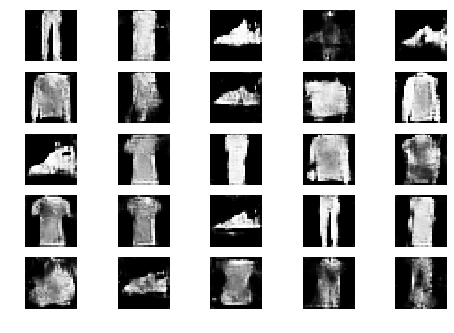

Epoch 0 Batch 701/1875 [D loss: 0.370424, acc.: 87.50%] [G loss: 1.962280]
Epoch 0 Batch 702/1875 [D loss: 0.323125, acc.: 87.50%] [G loss: 2.160093]
Epoch 0 Batch 703/1875 [D loss: 0.476600, acc.: 68.75%] [G loss: 2.528788]
Epoch 0 Batch 704/1875 [D loss: 0.372383, acc.: 71.88%] [G loss: 2.104691]
Epoch 0 Batch 705/1875 [D loss: 0.686906, acc.: 65.62%] [G loss: 1.811737]
Epoch 0 Batch 706/1875 [D loss: 0.394423, acc.: 81.25%] [G loss: 2.018687]
Epoch 0 Batch 707/1875 [D loss: 0.463785, acc.: 75.00%] [G loss: 1.826794]


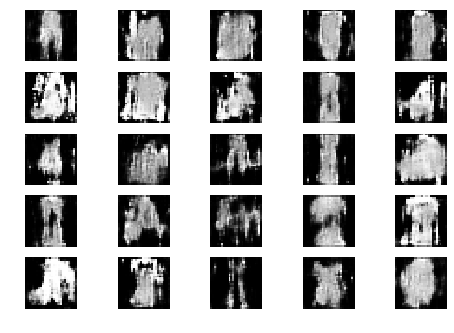

Epoch 0 Batch 708/1875 [D loss: 0.364998, acc.: 87.50%] [G loss: 2.414355]
Epoch 0 Batch 709/1875 [D loss: 0.297594, acc.: 87.50%] [G loss: 2.346178]
Epoch 0 Batch 710/1875 [D loss: 0.350167, acc.: 87.50%] [G loss: 2.261659]
Epoch 0 Batch 711/1875 [D loss: 0.501351, acc.: 81.25%] [G loss: 2.237941]
Epoch 0 Batch 712/1875 [D loss: 0.527352, acc.: 71.88%] [G loss: 2.049270]
Epoch 0 Batch 713/1875 [D loss: 0.300665, acc.: 90.62%] [G loss: 2.083025]
Epoch 0 Batch 714/1875 [D loss: 0.565128, acc.: 68.75%] [G loss: 2.227815]


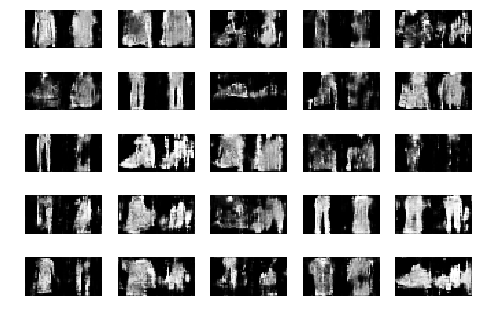

Epoch 0 Batch 715/1875 [D loss: 0.343030, acc.: 81.25%] [G loss: 1.968114]
Epoch 0 Batch 716/1875 [D loss: 0.368212, acc.: 84.38%] [G loss: 1.728613]
Epoch 0 Batch 717/1875 [D loss: 0.520376, acc.: 78.12%] [G loss: 1.765243]
Epoch 0 Batch 718/1875 [D loss: 0.446614, acc.: 78.12%] [G loss: 2.414590]
Epoch 0 Batch 719/1875 [D loss: 0.600074, acc.: 65.62%] [G loss: 1.680851]
Epoch 0 Batch 720/1875 [D loss: 0.721704, acc.: 56.25%] [G loss: 1.815107]
Epoch 0 Batch 721/1875 [D loss: 0.495056, acc.: 78.12%] [G loss: 1.583743]
Epoch 0 Batch 722/1875 [D loss: 0.549450, acc.: 62.50%] [G loss: 1.425590]
Epoch 0 Batch 723/1875 [D loss: 0.366279, acc.: 87.50%] [G loss: 1.845550]
Epoch 0 Batch 724/1875 [D loss: 0.507125, acc.: 81.25%] [G loss: 1.818890]
Epoch 0 Batch 725/1875 [D loss: 0.410812, acc.: 78.12%] [G loss: 2.610889]
Epoch 0 Batch 726/1875 [D loss: 0.658808, acc.: 71.88%] [G loss: 1.906013]
Epoch 0 Batch 727/1875 [D loss: 0.505243, acc.: 78.12%] [G loss: 1.972322]
Epoch 0 Batch 728/1875 [D

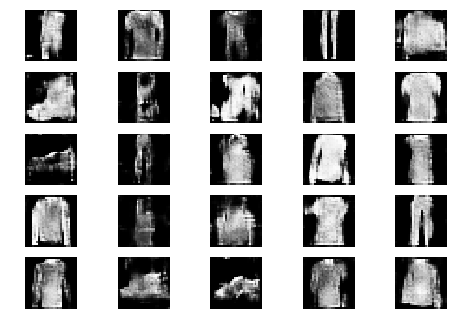

Epoch 0 Batch 801/1875 [D loss: 0.485987, acc.: 68.75%] [G loss: 2.538064]
Epoch 0 Batch 802/1875 [D loss: 0.470651, acc.: 81.25%] [G loss: 1.637515]
Epoch 0 Batch 803/1875 [D loss: 0.314599, acc.: 87.50%] [G loss: 2.110014]
Epoch 0 Batch 804/1875 [D loss: 0.532450, acc.: 68.75%] [G loss: 2.074734]
Epoch 0 Batch 805/1875 [D loss: 0.463028, acc.: 71.88%] [G loss: 1.851490]
Epoch 0 Batch 806/1875 [D loss: 0.538997, acc.: 68.75%] [G loss: 1.558474]
Epoch 0 Batch 807/1875 [D loss: 0.461495, acc.: 75.00%] [G loss: 2.037955]
Epoch 0 Batch 808/1875 [D loss: 0.486654, acc.: 75.00%] [G loss: 2.868408]


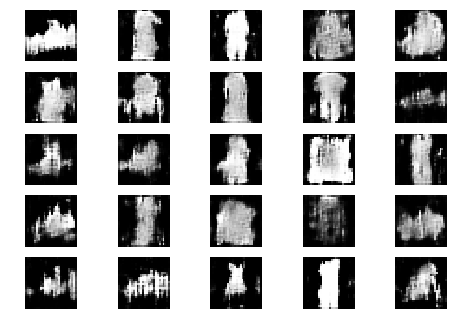

Epoch 0 Batch 809/1875 [D loss: 0.321540, acc.: 90.62%] [G loss: 2.093860]
Epoch 0 Batch 810/1875 [D loss: 0.690119, acc.: 65.62%] [G loss: 1.892323]
Epoch 0 Batch 811/1875 [D loss: 0.467337, acc.: 78.12%] [G loss: 1.715366]
Epoch 0 Batch 812/1875 [D loss: 0.396415, acc.: 81.25%] [G loss: 1.404266]
Epoch 0 Batch 813/1875 [D loss: 0.346168, acc.: 81.25%] [G loss: 2.046084]
Epoch 0 Batch 814/1875 [D loss: 0.416612, acc.: 78.12%] [G loss: 1.891090]
Epoch 0 Batch 815/1875 [D loss: 0.305722, acc.: 90.62%] [G loss: 2.358399]
Epoch 0 Batch 816/1875 [D loss: 0.394676, acc.: 81.25%] [G loss: 2.029713]


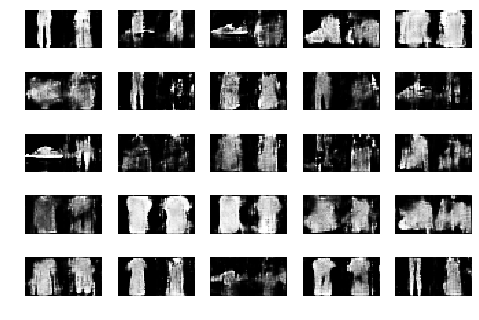

Epoch 0 Batch 817/1875 [D loss: 0.412302, acc.: 81.25%] [G loss: 1.504931]
Epoch 0 Batch 818/1875 [D loss: 0.373318, acc.: 81.25%] [G loss: 2.086174]
Epoch 0 Batch 819/1875 [D loss: 0.291534, acc.: 90.62%] [G loss: 1.855878]
Epoch 0 Batch 820/1875 [D loss: 0.307820, acc.: 87.50%] [G loss: 2.023384]
Epoch 0 Batch 821/1875 [D loss: 0.375649, acc.: 84.38%] [G loss: 2.407349]
Epoch 0 Batch 822/1875 [D loss: 0.364508, acc.: 81.25%] [G loss: 2.635949]
Epoch 0 Batch 823/1875 [D loss: 0.406439, acc.: 78.12%] [G loss: 1.953264]
Epoch 0 Batch 824/1875 [D loss: 0.518551, acc.: 71.88%] [G loss: 1.838977]
Epoch 0 Batch 825/1875 [D loss: 0.337304, acc.: 90.62%] [G loss: 1.671012]
Epoch 0 Batch 826/1875 [D loss: 0.489264, acc.: 75.00%] [G loss: 1.561751]
Epoch 0 Batch 827/1875 [D loss: 0.486040, acc.: 81.25%] [G loss: 1.807816]
Epoch 0 Batch 828/1875 [D loss: 0.454206, acc.: 81.25%] [G loss: 2.157722]
Epoch 0 Batch 829/1875 [D loss: 0.254090, acc.: 87.50%] [G loss: 1.951094]
Epoch 0 Batch 830/1875 [D

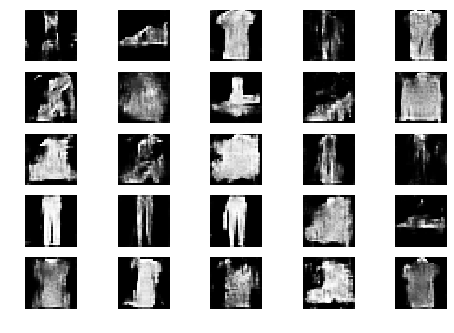

Epoch 0 Batch 901/1875 [D loss: 0.342978, acc.: 87.50%] [G loss: 2.442918]
Epoch 0 Batch 902/1875 [D loss: 0.356442, acc.: 90.62%] [G loss: 1.945548]
Epoch 0 Batch 903/1875 [D loss: 0.304849, acc.: 90.62%] [G loss: 2.025918]
Epoch 0 Batch 904/1875 [D loss: 0.391237, acc.: 84.38%] [G loss: 1.803350]
Epoch 0 Batch 905/1875 [D loss: 0.383920, acc.: 84.38%] [G loss: 1.617399]
Epoch 0 Batch 906/1875 [D loss: 0.383329, acc.: 78.12%] [G loss: 2.486063]
Epoch 0 Batch 907/1875 [D loss: 0.305937, acc.: 90.62%] [G loss: 2.542822]
Epoch 0 Batch 908/1875 [D loss: 0.385481, acc.: 84.38%] [G loss: 2.583108]
Epoch 0 Batch 909/1875 [D loss: 0.366567, acc.: 75.00%] [G loss: 2.342493]


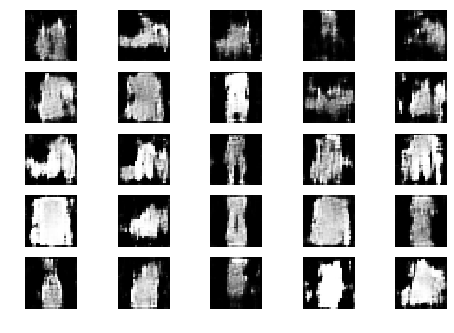

Epoch 0 Batch 910/1875 [D loss: 0.348685, acc.: 90.62%] [G loss: 1.884586]
Epoch 0 Batch 911/1875 [D loss: 0.330799, acc.: 84.38%] [G loss: 2.055217]
Epoch 0 Batch 912/1875 [D loss: 0.264856, acc.: 90.62%] [G loss: 2.113205]
Epoch 0 Batch 913/1875 [D loss: 0.385392, acc.: 84.38%] [G loss: 1.757880]
Epoch 0 Batch 914/1875 [D loss: 0.344906, acc.: 93.75%] [G loss: 1.673694]
Epoch 0 Batch 915/1875 [D loss: 0.323663, acc.: 93.75%] [G loss: 2.059540]
Epoch 0 Batch 916/1875 [D loss: 0.385225, acc.: 84.38%] [G loss: 2.313570]
Epoch 0 Batch 917/1875 [D loss: 0.303137, acc.: 87.50%] [G loss: 2.354425]
Epoch 0 Batch 918/1875 [D loss: 0.431151, acc.: 81.25%] [G loss: 2.319558]


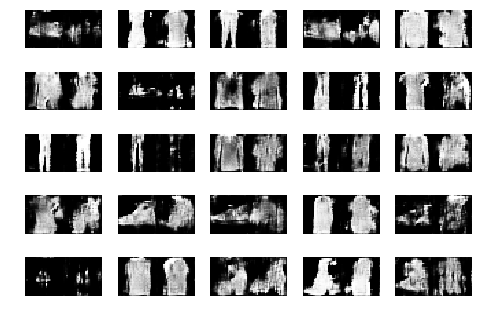

Epoch 0 Batch 919/1875 [D loss: 0.272291, acc.: 90.62%] [G loss: 2.629086]
Epoch 0 Batch 920/1875 [D loss: 0.379499, acc.: 87.50%] [G loss: 2.463284]
Epoch 0 Batch 921/1875 [D loss: 0.556873, acc.: 71.88%] [G loss: 1.809396]
Epoch 0 Batch 922/1875 [D loss: 0.416371, acc.: 81.25%] [G loss: 1.928930]
Epoch 0 Batch 923/1875 [D loss: 0.319540, acc.: 90.62%] [G loss: 2.469118]
Epoch 0 Batch 924/1875 [D loss: 0.237027, acc.: 96.88%] [G loss: 2.411668]
Epoch 0 Batch 925/1875 [D loss: 0.283897, acc.: 84.38%] [G loss: 2.640047]
Epoch 0 Batch 926/1875 [D loss: 0.539948, acc.: 71.88%] [G loss: 1.775748]
Epoch 0 Batch 927/1875 [D loss: 0.354168, acc.: 90.62%] [G loss: 2.024382]
Epoch 0 Batch 928/1875 [D loss: 0.290584, acc.: 90.62%] [G loss: 1.628089]
Epoch 0 Batch 929/1875 [D loss: 0.328404, acc.: 87.50%] [G loss: 1.486759]
Epoch 0 Batch 930/1875 [D loss: 0.363305, acc.: 84.38%] [G loss: 1.726641]
Epoch 0 Batch 931/1875 [D loss: 0.398063, acc.: 84.38%] [G loss: 1.711114]
Epoch 0 Batch 932/1875 [D

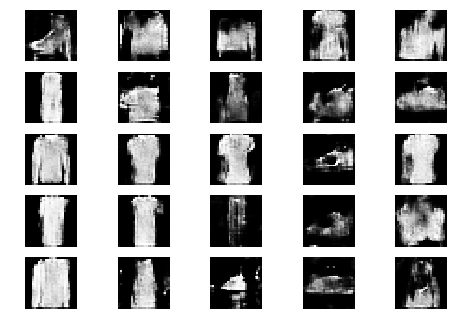

Epoch 0 Batch 1001/1875 [D loss: 0.368582, acc.: 84.38%] [G loss: 2.573434]
Epoch 0 Batch 1002/1875 [D loss: 0.443869, acc.: 78.12%] [G loss: 2.671701]
Epoch 0 Batch 1003/1875 [D loss: 0.441347, acc.: 71.88%] [G loss: 2.312413]
Epoch 0 Batch 1004/1875 [D loss: 0.311920, acc.: 84.38%] [G loss: 2.048120]
Epoch 0 Batch 1005/1875 [D loss: 0.529983, acc.: 56.25%] [G loss: 2.216820]
Epoch 0 Batch 1006/1875 [D loss: 0.480842, acc.: 78.12%] [G loss: 2.167163]
Epoch 0 Batch 1007/1875 [D loss: 0.253084, acc.: 90.62%] [G loss: 2.149153]
Epoch 0 Batch 1008/1875 [D loss: 0.271488, acc.: 90.62%] [G loss: 1.938538]
Epoch 0 Batch 1009/1875 [D loss: 0.480078, acc.: 75.00%] [G loss: 1.476756]
Epoch 0 Batch 1010/1875 [D loss: 0.300687, acc.: 90.62%] [G loss: 1.763048]


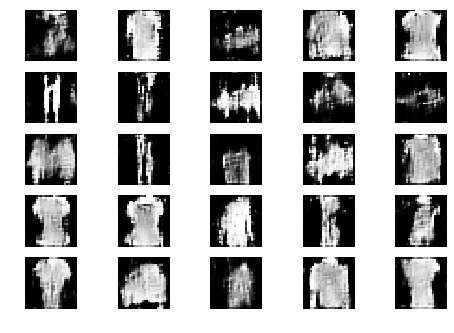

Epoch 0 Batch 1011/1875 [D loss: 0.464901, acc.: 71.88%] [G loss: 1.717772]
Epoch 0 Batch 1012/1875 [D loss: 0.374060, acc.: 81.25%] [G loss: 2.387760]
Epoch 0 Batch 1013/1875 [D loss: 0.323625, acc.: 81.25%] [G loss: 1.886989]
Epoch 0 Batch 1014/1875 [D loss: 0.166699, acc.: 100.00%] [G loss: 2.035265]
Epoch 0 Batch 1015/1875 [D loss: 0.445516, acc.: 75.00%] [G loss: 2.636918]
Epoch 0 Batch 1016/1875 [D loss: 0.703892, acc.: 62.50%] [G loss: 2.730812]
Epoch 0 Batch 1017/1875 [D loss: 0.398114, acc.: 84.38%] [G loss: 2.522729]
Epoch 0 Batch 1018/1875 [D loss: 0.439660, acc.: 75.00%] [G loss: 2.284456]
Epoch 0 Batch 1019/1875 [D loss: 0.281940, acc.: 90.62%] [G loss: 2.217865]
Epoch 0 Batch 1020/1875 [D loss: 0.366066, acc.: 78.12%] [G loss: 2.197307]


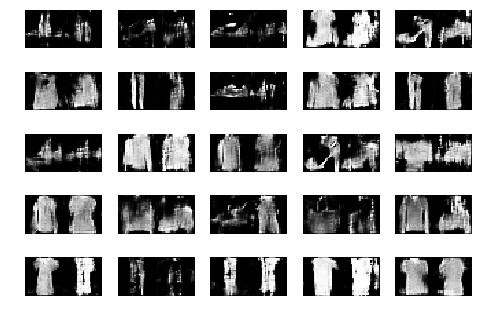

Epoch 0 Batch 1021/1875 [D loss: 0.303483, acc.: 90.62%] [G loss: 2.572279]
Epoch 0 Batch 1022/1875 [D loss: 0.473778, acc.: 78.12%] [G loss: 2.382162]
Epoch 0 Batch 1023/1875 [D loss: 0.537413, acc.: 78.12%] [G loss: 1.603185]
Epoch 0 Batch 1024/1875 [D loss: 0.433397, acc.: 87.50%] [G loss: 2.151955]
Epoch 0 Batch 1025/1875 [D loss: 0.355757, acc.: 84.38%] [G loss: 2.262212]
Epoch 0 Batch 1026/1875 [D loss: 0.303472, acc.: 90.62%] [G loss: 2.056858]
Epoch 0 Batch 1027/1875 [D loss: 0.307522, acc.: 96.88%] [G loss: 1.996212]
Epoch 0 Batch 1028/1875 [D loss: 0.504881, acc.: 75.00%] [G loss: 2.770827]
Epoch 0 Batch 1029/1875 [D loss: 0.254600, acc.: 90.62%] [G loss: 2.764922]
Epoch 0 Batch 1030/1875 [D loss: 0.359603, acc.: 90.62%] [G loss: 2.700830]
Epoch 0 Batch 1031/1875 [D loss: 0.311760, acc.: 81.25%] [G loss: 2.245903]
Epoch 0 Batch 1032/1875 [D loss: 0.248954, acc.: 87.50%] [G loss: 2.231013]
Epoch 0 Batch 1033/1875 [D loss: 0.381814, acc.: 84.38%] [G loss: 2.912910]
Epoch 0 Batc

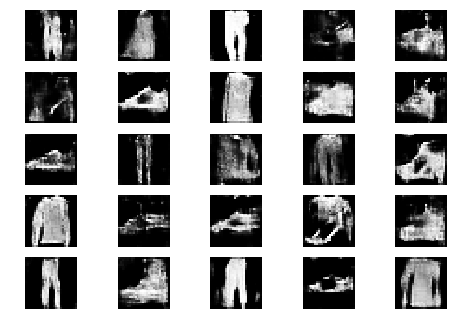

Epoch 0 Batch 1101/1875 [D loss: 0.410257, acc.: 87.50%] [G loss: 2.820316]
Epoch 0 Batch 1102/1875 [D loss: 0.447993, acc.: 78.12%] [G loss: 2.666844]
Epoch 0 Batch 1103/1875 [D loss: 0.359708, acc.: 87.50%] [G loss: 2.364004]
Epoch 0 Batch 1104/1875 [D loss: 0.368651, acc.: 81.25%] [G loss: 2.338932]
Epoch 0 Batch 1105/1875 [D loss: 0.369156, acc.: 84.38%] [G loss: 2.488587]
Epoch 0 Batch 1106/1875 [D loss: 0.264837, acc.: 87.50%] [G loss: 2.289599]
Epoch 0 Batch 1107/1875 [D loss: 0.415669, acc.: 78.12%] [G loss: 2.843492]
Epoch 0 Batch 1108/1875 [D loss: 0.197700, acc.: 100.00%] [G loss: 2.564568]
Epoch 0 Batch 1109/1875 [D loss: 0.455820, acc.: 84.38%] [G loss: 1.754796]
Epoch 0 Batch 1110/1875 [D loss: 0.311464, acc.: 87.50%] [G loss: 1.855945]
Epoch 0 Batch 1111/1875 [D loss: 0.256128, acc.: 93.75%] [G loss: 1.890062]


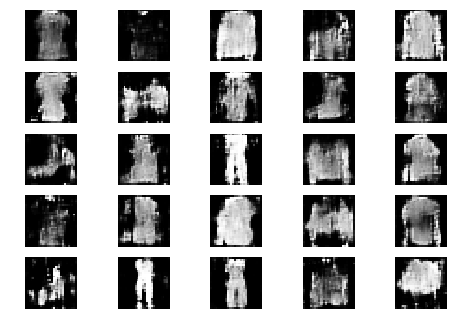

Epoch 0 Batch 1112/1875 [D loss: 0.359623, acc.: 84.38%] [G loss: 2.217046]
Epoch 0 Batch 1113/1875 [D loss: 0.248414, acc.: 93.75%] [G loss: 2.420307]
Epoch 0 Batch 1114/1875 [D loss: 0.356230, acc.: 71.88%] [G loss: 2.515004]
Epoch 0 Batch 1115/1875 [D loss: 0.491378, acc.: 78.12%] [G loss: 1.973900]
Epoch 0 Batch 1116/1875 [D loss: 0.333098, acc.: 87.50%] [G loss: 1.879648]
Epoch 0 Batch 1117/1875 [D loss: 0.228279, acc.: 87.50%] [G loss: 2.378292]
Epoch 0 Batch 1118/1875 [D loss: 0.414014, acc.: 75.00%] [G loss: 2.451273]
Epoch 0 Batch 1119/1875 [D loss: 0.289973, acc.: 90.62%] [G loss: 3.000368]
Epoch 0 Batch 1120/1875 [D loss: 0.305787, acc.: 87.50%] [G loss: 2.769355]
Epoch 0 Batch 1121/1875 [D loss: 0.266644, acc.: 90.62%] [G loss: 2.317533]
Epoch 0 Batch 1122/1875 [D loss: 0.262481, acc.: 90.62%] [G loss: 2.246851]


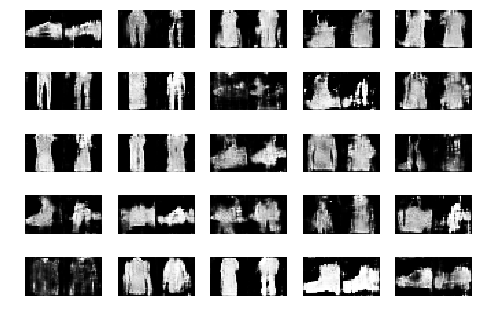

Epoch 0 Batch 1123/1875 [D loss: 0.251437, acc.: 90.62%] [G loss: 2.613652]
Epoch 0 Batch 1124/1875 [D loss: 0.358651, acc.: 84.38%] [G loss: 2.640167]
Epoch 0 Batch 1125/1875 [D loss: 0.221708, acc.: 100.00%] [G loss: 2.360523]
Epoch 0 Batch 1126/1875 [D loss: 0.409956, acc.: 75.00%] [G loss: 2.232068]
Epoch 0 Batch 1127/1875 [D loss: 0.335212, acc.: 81.25%] [G loss: 2.403744]
Epoch 0 Batch 1128/1875 [D loss: 0.438608, acc.: 78.12%] [G loss: 2.286149]
Epoch 0 Batch 1129/1875 [D loss: 0.382800, acc.: 84.38%] [G loss: 2.021972]
Epoch 0 Batch 1130/1875 [D loss: 0.292556, acc.: 90.62%] [G loss: 2.751539]
Epoch 0 Batch 1131/1875 [D loss: 0.502149, acc.: 75.00%] [G loss: 2.537607]
Epoch 0 Batch 1132/1875 [D loss: 0.351877, acc.: 84.38%] [G loss: 2.434248]
Epoch 0 Batch 1133/1875 [D loss: 0.249258, acc.: 93.75%] [G loss: 1.939593]
Epoch 0 Batch 1134/1875 [D loss: 0.504906, acc.: 68.75%] [G loss: 3.014981]
Epoch 0 Batch 1135/1875 [D loss: 0.368042, acc.: 87.50%] [G loss: 2.622212]
Epoch 0 Bat

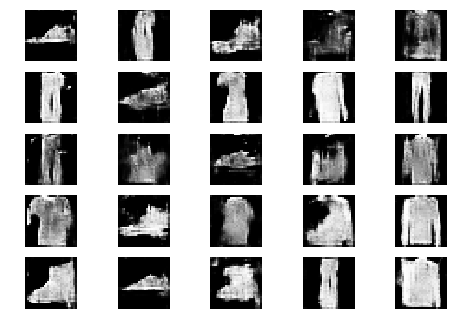

Epoch 0 Batch 1201/1875 [D loss: 0.322326, acc.: 87.50%] [G loss: 3.825676]
Epoch 0 Batch 1202/1875 [D loss: 0.538197, acc.: 65.62%] [G loss: 2.942776]
Epoch 0 Batch 1203/1875 [D loss: 0.505451, acc.: 78.12%] [G loss: 2.106725]
Epoch 0 Batch 1204/1875 [D loss: 0.367332, acc.: 84.38%] [G loss: 2.322773]
Epoch 0 Batch 1205/1875 [D loss: 0.205337, acc.: 96.88%] [G loss: 2.517448]
Epoch 0 Batch 1206/1875 [D loss: 0.312234, acc.: 84.38%] [G loss: 2.318029]
Epoch 0 Batch 1207/1875 [D loss: 0.374630, acc.: 84.38%] [G loss: 2.774663]
Epoch 0 Batch 1208/1875 [D loss: 0.268831, acc.: 90.62%] [G loss: 2.518714]
Epoch 0 Batch 1209/1875 [D loss: 0.297595, acc.: 87.50%] [G loss: 1.930432]
Epoch 0 Batch 1210/1875 [D loss: 0.330629, acc.: 93.75%] [G loss: 2.321154]
Epoch 0 Batch 1211/1875 [D loss: 0.388563, acc.: 81.25%] [G loss: 2.299949]
Epoch 0 Batch 1212/1875 [D loss: 0.263266, acc.: 87.50%] [G loss: 2.023355]


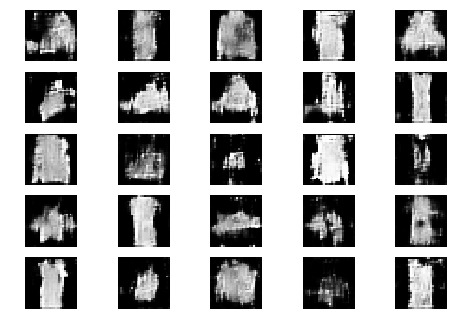

Epoch 0 Batch 1213/1875 [D loss: 0.308989, acc.: 84.38%] [G loss: 2.008896]
Epoch 0 Batch 1214/1875 [D loss: 0.232054, acc.: 90.62%] [G loss: 1.893774]
Epoch 0 Batch 1215/1875 [D loss: 0.317525, acc.: 87.50%] [G loss: 1.887789]
Epoch 0 Batch 1216/1875 [D loss: 0.360831, acc.: 84.38%] [G loss: 2.566890]
Epoch 0 Batch 1217/1875 [D loss: 0.464424, acc.: 78.12%] [G loss: 2.836084]
Epoch 0 Batch 1218/1875 [D loss: 0.256635, acc.: 90.62%] [G loss: 2.953481]
Epoch 0 Batch 1219/1875 [D loss: 0.366297, acc.: 81.25%] [G loss: 2.555363]
Epoch 0 Batch 1220/1875 [D loss: 0.364815, acc.: 90.62%] [G loss: 2.990822]
Epoch 0 Batch 1221/1875 [D loss: 0.468449, acc.: 78.12%] [G loss: 2.175734]
Epoch 0 Batch 1222/1875 [D loss: 0.217371, acc.: 93.75%] [G loss: 2.352907]
Epoch 0 Batch 1223/1875 [D loss: 0.297799, acc.: 90.62%] [G loss: 2.390378]
Epoch 0 Batch 1224/1875 [D loss: 0.326100, acc.: 84.38%] [G loss: 2.467217]


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=4, batch_size=32, save_interval=1, modeltotrain = 3)

In [0]:

generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 2 ,  loadpretrainedweights=True)




    
    

    


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=1, modeltotrain = 3)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNandriNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=64, save_interval=1, modeltotrain = 3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=4, batch_size=64, save_interval=1, modeltotrain = 3)

In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
!rm -rf generator1fminst.h5



In [0]:

generator1.save('generator1fminst.h5')



In [0]:
files.download('generator1fminst.h5')


In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=1, batch_size=32, save_interval=20, modeltotrain=3)

In [0]:
!rm -rf generator2fmnist.h5


In [0]:

generator2.save('generator2fmnist.h5')

In [0]:
!ls -al


In [0]:
files.download('generator2fmnist.h5')

In [0]:
##!wget https://github.com/rajagopalmotivate/try1/raw/master/generatorTrainedepoch2git.h5

In [0]:
!rm -rf generator1fminst.h5
!rm -rf generator2fminst.h5

In [0]:
!ls -all

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator1fminst.h5

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator2fminst.h5

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
plotamodel(combined, showdetails=True )
files.download('model.png')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=1)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
plotamodel(combined)
files.download('model.png')

In [0]:
!rm -rf generatorTrainedepoch2.h5

generator1.save('generator1fminst.h5')

!rm -rf generator2Trainedepoch2.h5

generator2.save('generator2fminst.h5')


In [0]:
generator1 = generator1.load_weights('generator1fmnist.h5')


In [0]:
generator2 = generator2.load_weights('generator1fminst.h5')




In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
generator1.save('generatorTrained1epoch4.h5')

In [0]:
files.download('generator1fmnist.h5')

In [0]:
files.download('generator2fmnist.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

